<h1> Titanic </h1>

The dataset contains the list of passengers and information about each passenger. The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

Reference: https://jaketae.github.io/study/sklearn-pipeline/

<h2 style="background-color:rgba(100,100,100,0.5);"> Frame the problem </h2>

Titanic survival predictor is clearly a typical supervised learning task, since you are given labeled training examples.

It is also a typical classification task, since you are asked to classify whether a passenger is a survivor or not.

Finally, there is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.

<h2 style="background-color:rgba(100,100,100,0.5);"> Fetch and load data </h2>


In [126]:
from sklearn.datasets import fetch_openml

# Fetch the data
# as_Frame=True will fetch data as pandas dataframe
# as_Frame=False will fetch data as array
titanic = fetch_openml('titanic', version=1, as_frame=True)
titanic.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

<h2 style="background-color:rgba(100,100,100,0.5);"> Analyze the data and its structure </h2>

In [127]:
X, y = titanic["data"], titanic["target"]

# Display shape
print(X.shape)
print(y.shape)

# Display head
print(X.head())
print(y.head())

# Display info
print(X.info())

# Display percentage of missing values for each attribute
print(X.isnull().sum() / len(X) * 100)

(1309, 13)
(1309,)
   pclass                                             name     sex      age  \
0     1.0                    Allen, Miss. Elisabeth Walton  female  29.0000   
1     1.0                   Allison, Master. Hudson Trevor    male   0.9167   
2     1.0                     Allison, Miss. Helen Loraine  female   2.0000   
3     1.0             Allison, Mr. Hudson Joshua Creighton    male  30.0000   
4     1.0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0000   

   sibsp  parch  ticket      fare    cabin embarked  boat   body  \
0    0.0    0.0   24160  211.3375       B5        S     2    NaN   
1    1.0    2.0  113781  151.5500  C22 C26        S    11    NaN   
2    1.0    2.0  113781  151.5500  C22 C26        S  None    NaN   
3    1.0    2.0  113781  151.5500  C22 C26        S  None  135.0   
4    1.0    2.0  113781  151.5500  C22 C26        S  None    NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chest

<h3><b>How many instances are there in the dataset</b></h3>

There are 1309 values in the data set, which is not very large.

<h3><b>Are there missing values (non-null) for any attributes</b></h3>

>Data cleaning will need to be done to address any missing values

The age, fare, embarked, cabin, boat, body and home destination are sometimes null.

The cabin, boat, body and home destination have a lot of null values (as indicated by the percentage of null values), it will be difficult to impute these values, we will drop these instead.

The age has some null values, we can possibly use the median age as replacement for the null values. For, the fare and embarked, we can possibly use the most frequently occuring categorical value.

<h3><b>What are the numerical and categorical attributes</b></h3>

>Categorical attributes will need to be mapped to numerical values (encoding)

The pclass, sex and embarked are categorical attributes.

The name and ticket attributes may have some value, but they are of type object and will be a bit tricky to convert into useful numbers that a model can consume. We can infer the title (Miss, Mrs.etc.) from name and ignore the actual name, and drop ticket attribute.

In [128]:
X.describe()

,pclass,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000


<h3><b> Preview the center and dispersion of the features </b></h3>

The mean fare was approximately 33 pounds which does not seem so expensive (but it was probably a lot of money back then). The mean age was less than 30 years old.

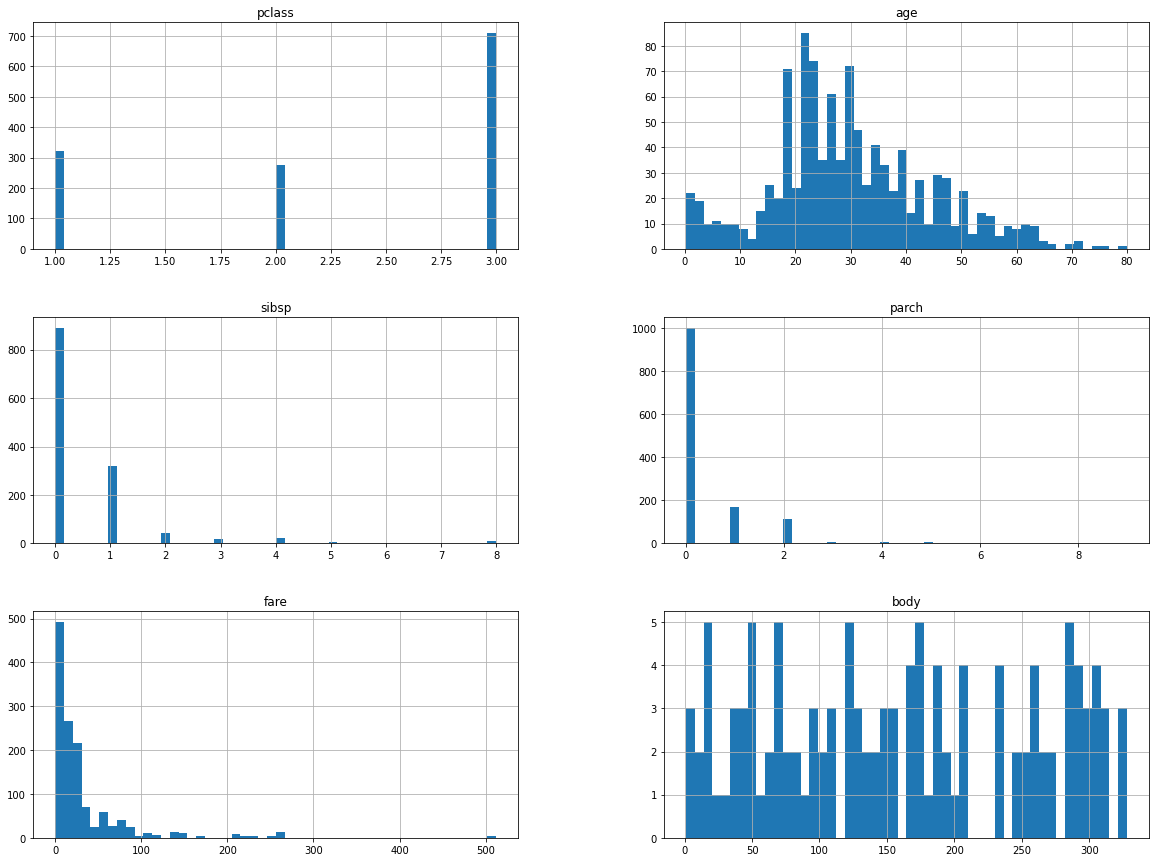

In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
X.hist(bins=50, figsize=(20, 15))
plt.show()

<h3><b>Plot the distributions for the features</b></h3>

The three keys to describing the distributions are shape, center, and spread.
Consider clusters, gaps, modes, and outliers.
Look for reasons behind any unusual features.

Shape:
>A few common shapes are symmetric, skewed to the right, skewed to the left, bell-shaped, and uniform distributions. Consider transforming tail-heavy distributions to be more bell-shaped.

Spread:
>Check whether the end values in the range have been capped. For these capped values, either collect actual values to replace the capped values or remove the values from the dataset (The system should not be evaluated poorly if it predicts values beyond the capped values).

>Understand the units for each distribution, whether any scaling has been applied. Consider apply feature scaling for features with different scales (Machine Learning algorithms usually don’t perform well when the input numerical attributes have very different scales).

We're ignoring the fare and body attributes for now, so don't need to look into much for these distributions. The pclass is a categorical attribute and the sbisp, parch attributes are discrete values - these all show the expected distributions.

The age distribution seems to have the expected shape of a normal distribution and does not seem to have any capped values.

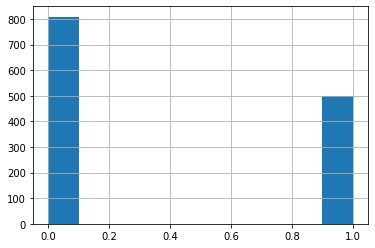

0.3819709702062643


In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a pandas series with numbers instead of string ('0', '1')
# Most ML algorithms expect numbers, not strings
y = y.astype(np.uint8)
y.hist()
plt.show()

# Display how many out of the total passengers survived
print(y.mean())

<h2 style="background-color:rgba(100,100,100,0.5);"> Sample the data for testing and training purposes </h2>

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split(), we'll use this with the random_state parameter. Also, since this function can accept multiple datasets with an identical number of rows, and it will split them on the same indices, we can use it to split both the data and target (we'll use stratify on the target so the test and training data will have similar distribution for the target as the original data).

In [181]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

<h2 style="background-color:rgba(100,100,100,0.5);"> Discover and visualize the data to gain insights </h2>

First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small, so you can just work directly on the full set. Let’s create a copy so that you can play with it without harming the training set:

In [132]:
titanic = X_train.copy()

<h3><b>Experimenting with Attribute Combinations</b></h3>

Sometimes, weakly correlated features can be combined together to form a new feature, which might exhibit higher correlation with respect to the target. Identify any attribute combinations that might be more correlated to the target value.

In [133]:
# https://jaketae.github.io/study/sklearn-pipeline/
# We can combine parch and sibsp into a new feature, called family_size. 
# Strictly speaking, we would have to add 1, but adding all values by one corresponds to shifting
# everything by a constant value, which will not affect modeling since such constant adjustments
# will be taken care of by the preprocessing step anyway.

titanic["family_size"] = titanic["parch"] + titanic["sibsp"]
titanic.drop(["parch", "sibsp"], axis=1, inplace=True)

# We can add a title (obtained from name), update rare titles
titanic["title"] = titanic["name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
titanic.drop(["name"], axis=1, inplace=True)

rare_titles = (titanic["title"].value_counts() < 10)
titanic["title"].loc[titanic.title == 'Miss'] = 'Mrs'
titanic["title"] = titanic.title.apply(lambda x: 'rare' if rare_titles[x] else x)

print(titanic.head())

      pclass     sex   age    ticket      fare cabin embarked  boat  body  \
191      1.0    male  30.0    113801   45.5000  None        S  None   NaN   
373      2.0  female  28.0      2003   26.0000  None        S    14   NaN   
1165     3.0    male  25.0      2672    7.2250  None        C  None   NaN   
705      3.0    male   NaN      2689   14.4583  None        C  None   NaN   
229      1.0  female  17.0  PC 17758  108.9000   C65        C     8   NaN   

                        home.dest  family_size title  
191         London / New York, NY          0.0    Mr  
373   England / San Francisco, CA          1.0   Mrs  
1165                         None          0.0    Mr  
705                    Ottawa, ON          1.0    Mr  
229                 Madrid, Spain          1.0   Mrs  


C:\Program Files\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<h2 style="background-color:rgba(100,100,100,0.5);"> Prepare the Data for Machine Learning Algorithms </h2>

Data cleaning is required for this data set to clean up missing attributes.

Feature scaling can be useful to improve the performance of the models.

Custom transformation is needed (as seen above) to add family_size and title attributes.

Ffirst let’s revert to a clean training set (by copying X_train once again):

In [134]:
titanic = X_train.copy()

<h3><b> Data Cleaning - Missing attributes </b></h3>

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We earlier identified the attributes with missing values, so let’s fix this. You have three options:

<ol type="1">
    <li>Get rid of the corresponding districts</li>
    <li>Get rid of the whole attribute</li>
    <li>Set the values to some value (zero, the mean, the median etc.)</li>
</ol>

You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna() methods:

In [135]:
titanic.drop("cabin", axis=1, inplace=True)       # option 2
titanic.drop("boat", axis=1, inplace=True)       # option 2
titanic.drop("body", axis=1, inplace=True)       # option 2
titanic.drop("home.dest", axis=1, inplace=True)       # option 2
titanic.drop("ticket", axis=1, inplace=True)       # option 2

print(titanic.head())

      pclass                                               name     sex   age  \
191      1.0                         Loring, Mr. Joseph Holland    male  30.0   
373      2.0        Clarke, Mrs. Charles V (Ada Maria Winfield)  female  28.0   
1165     3.0                                   Saad, Mr. Khalil    male  25.0   
705      3.0                                  Caram, Mr. Joseph    male   NaN   
229      1.0  Penasco y Castellana, Mrs. Victor de Satode (M...  female  17.0   

      sibsp  parch      fare embarked  
191     0.0    0.0   45.5000        S  
373     1.0    0.0   26.0000        S  
1165    0.0    0.0    7.2250        C  
705     1.0    0.0   14.4583        C  
229     1.0    0.0  108.9000        C  


For the age, fare and embarked missing values, we'll use the imputer directly in the pipeline later to transform the missing values.

<h3><b> Data Cleaning - Handling text and categorical attributes </b></h3>

Most Machine Learning algorithms prefer to work with numbers, so convert categories from text to numbers.

For this, we will use the encoder directly in the pipeline later to encode these values.

<h3><b> Feature Scaling </b></h2>

One of the most important transformations you need to apply to your data is feature scaling. 

For this, we will use the scaler directly in the pipeline later to scale these values.

<h3><b> Custom Transformers </b></h3>

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods: fit() (returning self), transform(), and fit_transform().

You can get the last one for free by simply adding TransformerMixin as a base class. If you add BaseEstimator as a base class (and avoid *args and **kargs in your constructor), you will also get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning.

In [136]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedNumAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_family_size=True, delete_parch_sibsp=True):
        self.add_family_size = add_family_size
        self.delete_parch_sibsp = delete_parch_sibsp
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        X_transform = X.copy()        

        if self.add_family_size:
            X_transform["family_size"] = X_transform["parch"] + X_transform["sibsp"]
        if self.delete_parch_sibsp:
            X_transform.drop(["parch", "sibsp"], axis=1, inplace=True)

        return X_transform

class CombinedCatAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_title=True, delete_name=True):
        self.add_title = add_title
        self.delete_name = delete_name
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        X_transform = X.copy()        

        if self.add_title:
            X_transform["title"] = X_transform["name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
            rare_titles = (X_transform["title"].value_counts() < 10)
            X_transform["title"].loc[X_transform.title == 'Miss'] = 'Mrs'
            X_transform["title"] = X_transform.title.apply(lambda x: 'rare' if rare_titles[x] else x)
        if self.delete_name:
            X_transform.drop(["name"], axis=1, inplace=True)

        return X_transform

num_attr_adder = CombinedNumAttributesAdder()
cat_attr_adder = CombinedCatAttributesAdder()

titanic_extra_attribs = cat_attr_adder.transform(num_attr_adder.transform(titanic))

print(titanic_extra_attribs.head())

      pclass     sex   age      fare embarked  family_size title
191      1.0    male  30.0   45.5000        S          0.0    Mr
373      2.0  female  28.0   26.0000        S          1.0   Mrs
1165     3.0    male  25.0    7.2250        C          0.0    Mr
705      3.0    male   NaN   14.4583        C          1.0    Mr
229      1.0  female  17.0  108.9000        C          1.0   Mrs


C:\Program Files\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<h3><b> Transformation Pipelines </b></h3>

Scikit-Learn provides the Pipeline class to help with sequences of transformations.

Pipeline for numerical attributes:

Since the default imputer returns a numpy array but our custom transformer (for adding attributes) deals with pandas dataframe, we can write a wrapper class to return a dataframe instead.

In [137]:
from sklearn.impute import SimpleImputer

class PandasSimpleImputer(SimpleImputer):
    """A wrapper around `SimpleImputer` to return data frames with columns.
    """
    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X, y)

    def transform(self, X):
        return pd.DataFrame(super().transform(X), columns=self.columns)

In [138]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

num_pipeline = Pipeline([
    ('imputer', PandasSimpleImputer(strategy="median")),
    ('attribs_adder', CombinedNumAttributesAdder()),
    ('robust_scaler', RobustScaler())
])

cat_attribs = ["pclass", "name", "sex", "embarked"]
titanic_num = titanic.drop(cat_attribs, axis=1)
titanic_num_tr = num_pipeline.fit_transform(titanic_num)

Pipeline for categorical attributes:

In [139]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

cat_pipeline = Pipeline([
    ('imputer', PandasSimpleImputer(strategy="most_frequent")),
    ('attribs_adder', CombinedCatAttributesAdder()),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(n_components=10))
])

num_attribs = ["age", "sibsp", "parch", "fare"]
titanic_cat = titanic.drop(num_attribs, axis=1)
titanic_cat_tr = cat_pipeline.fit_transform(titanic_cat)

<h3><b> Single Transformer Composition </b></h3>

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the ColumnTransformer for this purpose

In [140]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

titanic_prepared = full_pipeline.fit_transform(titanic)

<h2 style="background-color:rgba(100,100,100,0.5);"> Select and Train Models </h2>

Select a model that you think might work best first. Train and evaluate the performance of this model. The model might fit correctly, underfit or overfit the actual data.

The general approach when a particular model doesn't quite fit perfectly, is to try out many other models from various categories of Machine Learning algorithms (e.g., several Support Vector Machines with different kernels, and possibly a neural network), without spending too much time tweaking the hyperparameters for a particular model.

The goal is to shortlist a few (two to five) promising models.


<h3><b> Training and Evaluating on the Training Set </b></h3>

Select a model to train and evaluate on the data set.

Let's start with the RandomForestClassifier.

<h3><b> Predict values for some data inputs </b></h3>

In [141]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

forest_clf.fit(titanic_prepared, y_train)

print(forest_clf.predict(titanic_prepared[:1]))

[0]


<h3><b> Measure the performance of the model on the whole training set </b></h3>

Evaluating a classifier is often significantly trickier than evaluating a regressor. There are many performance measures available.

One measure is Accurracy, let's use K-fold cross validation to measure the accurracy.

In [142]:
from sklearn.model_selection import cross_val_score

cross_val_score(forest_clf, titanic_prepared, y_train, cv=3, scoring="accuracy")

array([0.80229226, 0.83094556, 0.79942693])

We have an accuracy of around 78% (on average).

<h3><b> Confusion Matrix </b></h3>

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).



In [143]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(forest_clf, titanic_prepared, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[555,  92],
       [106, 294]], dtype=int64)

<h3><b> Precision and Recall </b></h3>

precision = TP/(TP + FP)

recall = TP/(TP + FN) (also called sensitivity, true positive rate (TPR))

Other terms:

FPR = FP/(FP + TN)

TNR = TN/(FP + TN) (also called specificity)

In [144]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))

0.7616580310880829
0.735


<h3><b> F1 score </b></h3>

<img src="images/f1.png">


In [145]:
from sklearn.metrics import f1_score

print(f1_score(y_train, y_train_pred))

0.7480916030534353


The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection).

On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the <b><i>precision/recall trade-off</i></b>.

<h3><b> Precision-Recall (PR) Curve </b></h3>

The plots of precision and recall for different threshold values is called the PR curve.

 The RandomForestClassifier class has a predict_proba() method which returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class:

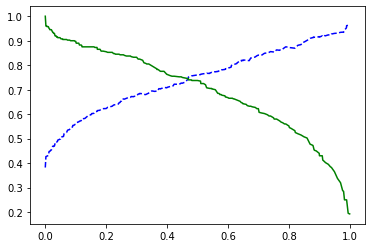

In [146]:
from sklearn.metrics import precision_recall_curve

y_probas = cross_val_predict(forest_clf, titanic_prepared, y_train, cv=3,
                             method="predict_proba")

y_scores = y_probas[:, 1]   # score = probability of positive class

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

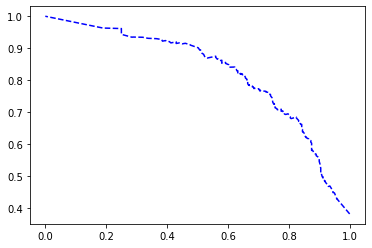

In [147]:
plt.plot(recalls, precisions, "b--",)
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. You look up the first plot and find the threshold value.

To be more precise you can search for the lowest threshold that gives you at least 90% precision. To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can use the threshold with the scores:

In [148]:
y_train_pred_90 = (y_scores >= .9)

print(precision_score(y_train, y_train_pred_90))
print(recall_score(y_train, y_train_pred_90))

0.9166666666666666
0.44


The default threshold value is .5. This corresponds to saying that surviving vs not surviving is 50% probable. So, if the probability score is greater than .5, we're accepting it as a survival 5 and if it is less than .5, we're accepting it as not a survival. 

Here, we're changing this threshold value to be .9 and evaluate what scores we get for the precision and recall.

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. But wait, not so fast. A high-precision classifier is not very useful if its recall is too low!

If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”

<h3><b> ROC Curve </b></h3>

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.

It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity.

Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [149]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

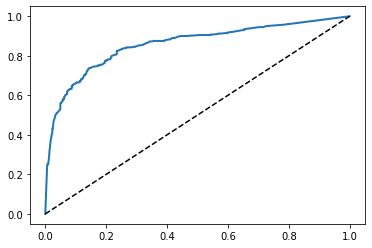

In [161]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [151]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train, y_scores))

0.8569513137557959


<h3><b> ROC vs PR Curve </b></h3>

Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use.

As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.

<h3><b> Try other models and measure scores </b></h3>

Let’s now train a SGDClassifier and compare its ROC curve and ROC AUC score to those of the RandomForestClassifier. First, you need to get scores for each instance in the training set. We can use the decision_function() method of the SGDClassifier class to get the scores (equivalent to the predict_proba() method of the RandomForestClassifier class). Scikit-Learn classifiers generally have one or the other, or both.

In [159]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
y_scores_sgd = cross_val_predict(sgd_clf, titanic_prepared, y_train, cv=3,
                             method="decision_function")

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train, y_scores_sgd)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare.

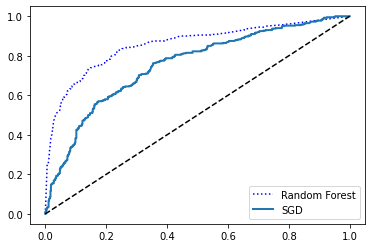

In [158]:
plt.plot(fpr, tpr, "b:", label="Random Forest")
plot_roc_curve(fpr_sgd, tpr_sgd, "SGD")
plt.legend(loc="lower right")
plt.show()

In [162]:
print(roc_auc_score(y_train, y_scores_sgd))

y_scores_sgd = cross_val_predict(sgd_clf, titanic_prepared, y_train, cv=3)
print(precision_score(y_train, y_scores_sgd))
print(recall_score(y_train, y_scores_sgd))

0.7434157650695518
0.7053140096618358
0.73


Based on the ROC AUC score, precision and recall scores, it looks like the Random Forest classifier is the better among the two.

In [163]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
y_scores_knn = cross_val_predict(knn_clf, titanic_prepared, y_train, cv=3)

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_scores_knn)

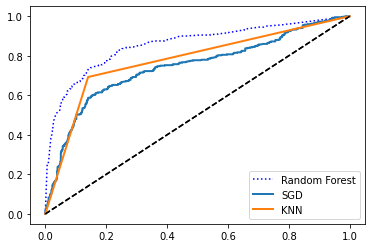

In [164]:
plt.plot(fpr, tpr, "b:", label="Random Forest")
plot_roc_curve(fpr_sgd, tpr_sgd, "SGD")
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plt.legend(loc="lower right")
plt.show()

In [165]:
print(roc_auc_score(y_train, y_scores_knn))
print(precision_score(y_train, y_scores_knn))
print(recall_score(y_train, y_scores_knn))

0.7759254250386398
0.7527173913043478
0.6925


Based on the ROC AUC score, precision and recall scores, it looks like the Random Forest classifier is the better among the three.

<h2 style="background-color:rgba(100,100,100,0.5);"> Fine-Tune Your Model </h2>

After shortlisting some promising models, you need to fine-tune the models.

Grid Search
One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead, you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values.

For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor for the 5's classifier.

In [172]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'n_estimators': [100, 200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [5, 7, 10]
    },
]

grid_search = GridSearchCV(forest_clf, param_grid, cv=3)
grid_search.fit(titanic_prepared, y_train)

print(grid_search.best_params_)

{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 500}


<h2 style="background-color:rgba(100,100,100,0.5);"> Analyze the Best Models and Their Errors </h2>

You will often gain good insights on the problem by inspecting the best models.

First, look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function (for the default threshold value):

In [179]:
forest_clf = grid_search.best_estimator_

y_train_pred = cross_val_predict(forest_clf, titanic_prepared, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

print(conf_mx)

[[585  62]
 [113 287]]


It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s matshow() function:

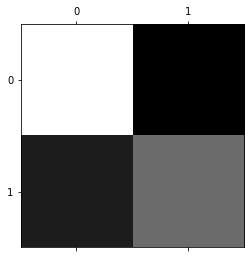

In [174]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

A good confusiong matrix will have most images on the main diagonal which means that they were classified correctly. The survived look darker than the not survived, which could mean that there are fewer survived in the dataset or that the classifier does not perform as well on the survived as on the non-survived. In fact, you can verify that both are the case.

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad), then fill the diagonal with zeros to keep only the errors, and plot the result.

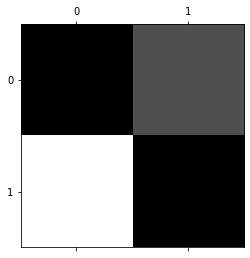

In [175]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

plt.show()

The rows represent actual classes, while columns represent predicted classes. It looks like the classifier misses a lot of survived classifications (false negatives).

Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 5s. For example, you could try to gather more training data for this category. Or you could engineer new features.

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming.

<h2 style="background-color:rgba(100,100,100,0.5);"> Evaluate Your System on the Test Set </h2>

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set.

There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform — you do not want to fit the test set!), and evaluate the final model on the test set.


In [184]:
from sklearn.metrics import classification_report

final_model =  grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(X_test.drop(["cabin", "boat", "body", "home.dest", "ticket"],
                                                      axis=1))
y_test_pred = final_model.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       162
           1       0.90      0.75      0.82       100

    accuracy                           0.87       262
   macro avg       0.88      0.85      0.86       262
weighted avg       0.88      0.87      0.87       262



<h2 style="background-color:rgba(100,100,100,0.5);"> Summary </h2>

This exercise demonstrates how to do build a classification model for the titanic data set. This presents an overview of the steps, but does not exhaustively consider all possible different models, nor does it select the best possible hyperparameters but, nevertheless performs reasonably well based on the scores.